# Volume-mean temperature

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.stats import linregress

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=64e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42497 instead
  expected, actual


In [4]:
client

Client Scheduler: tcp://127.0.0.1:37479 Dashboard: http://127.0.0.1:42497/status,Cluster Workers: 4 Cores: 8 Memory: 238.42 GiB


In [5]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
elif machine == 'nesh':
    esmdir2 = '/gxfs_work1/geomar/smomw352/esm-slask/'
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'

## Read NEMO grid

In [6]:
# On sci
#ds_mesh = xr.open_dataset('/data/user/jkjellsson/orca05_mesh_mask.nc')
ds_mesh = xr.open_dataset('/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc')
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_3D = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})

## Functions for area-mean and volume-mean calculations

In [ ]:
def area_mean(da):
    wgt = da_orca05_area
    wgt.name = 'weight'
    da_wgt = da.weighted(wgt)
    da_mean = da_wgt.mean(('x','y'))
    return da_mean

def volume_mean(da):
    wgt = da_orca05_volume
    wgt.name = 'weight'
    da_wgt = da.weighted(wgt)
    da_mean = da_wgt.mean(('x','y','deptht'))
    return da_mean

## Read OpenIFS grid

In [7]:
red_grid = '/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK001/outdata/oifs/ECE3_fx_18500101_reduced_sfc.nc'
ds_grid_r = xr.open_dataset(red_grid)
da_lon_r = ds_grid_r['lon']
da_lat_r = ds_grid_r['lat']
da_lsm_r = ds_grid_r['lsm'][0,:] # Fraction of land in each grid box 
da_cl_r = ds_grid_r['cl'][0,:] # Fraction of lake in each grid box
da_sea_r = 1.0 - (da_lsm_r + da_cl_r) # Fraction of sea in each grid box (not Caspian)

red_area = '/gxfs_work1/geomar/smomw352/esm-slask/FOCI_NJK007/input/oasis3mct/areas.nc'
ds_area_r = xr.open_dataset(red_area)
da_area_r = ds_area_r['A096.srf'][0,:].rename({'x_A096':'cell'})

Text(0.5, 1.0, 'Cell area [km2]')

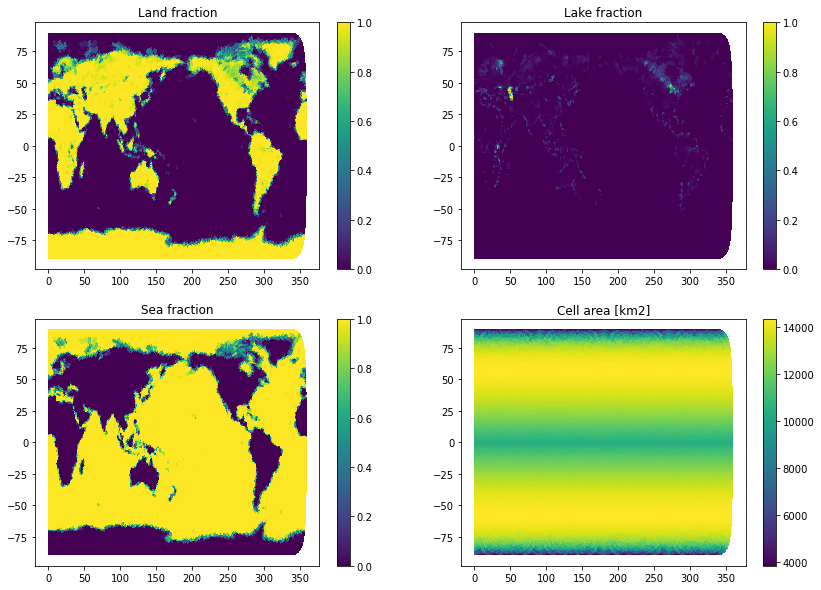

In [8]:
fig, axs = plt.subplots(2,2,figsize=(14,10))
ax = axs.flat
cf = ax[0].tripcolor(da_lon_r.values, da_lat_r.values, da_lsm_r.values)
plt.colorbar(cf,ax=ax[0])
ax[0].set_title('Land fraction')
cf = ax[1].tripcolor(da_lon_r.values, da_lat_r.values, da_cl_r.values)
plt.colorbar(cf,ax=ax[1])
ax[1].set_title('Lake fraction')
cf = ax[2].tripcolor(da_lon_r.values, da_lat_r.values, da_sea_r.values)
plt.colorbar(cf,ax=ax[2])
ax[2].set_title('Sea fraction')
cf = ax[3].tripcolor(da_lon_r.values, da_lat_r.values, da_area_r.values / 1e6)
plt.colorbar(cf,ax=ax[3])
ax[3].set_title('Cell area [km2]')

## Read NEMO

In [7]:
#exp_list = ['focioifs-merge14']
#exp_list = ['FOCI_GJK001','foci-cpl-06']
#time_list = [slice('1850-01-01','3000-01-01'), slice('1850-01-01','3150-01-01')]
#exp_list = ['FOCI_NJK007_cont3']

exp_list = ['FOCI_GJK016']
time_list = [slice('4000-01-01','4500-01-01')]

In [10]:
# OpenIFS surface
ds_sfc_all = []
for (time,exp) in zip(time_list,exp_list):
    if exp == 'FOCI_NJK007':
        sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir2,exp)
    else:
        sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/1y/*1y*regular_sfc.nc


In [11]:
# OpenIFS surface (reduced)
ds_sfc_r_all = []
for (time,exp) in zip(time_list,exp_list):
    if exp == 'FOCI_NJK007':
        sfc = '%s/%s/outdata/oifs/1y/*1y*reduced_sfc.nc' % (esmdir2,exp)
    else:
        sfc = '%s/%s/outdata/oifs/1y/*1y*reduced_sfc.nc' % (esmdir,exp)
    print(sfc)
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_r_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*reduced_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/1y/*1y*reduced_sfc.nc


In [12]:
ds_sfc_r_all[0]

<xarray.Dataset>
Dimensions:            (bnds: 2, cell: 40320, nvertex: 4, time: 1000)
Coordinates:
  * time               (time) object 1850-07-01 06:00:00 ... 2849-07-01 06:00:00
    lon                (cell) float32 dask.array<chunksize=(40320,), meta=np.ndarray>
    lat                (cell) float32 dask.array<chunksize=(40320,), meta=np.ndarray>
Dimensions without coordinates: bnds, cell, nvertex
Data variables: (12/25)
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    lon_bnds           (time, cell, nvertex) float32 dask.array<chunksize=(10, 40320, 4), meta=np.ndarray>
    lat_bnds           (time, cell, nvertex) float32 dask.array<chunksize=(10, 40320, 4), meta=np.ndarray>
    es                 (time, cell) float32 dask.array<chunksize=(10, 40320), meta=np.ndarray>
    sf                 (time, cell) float32 dask.array<chunksize=(10, 40320), meta=np.ndarray>
    sshf               (time, cell) float32 dask.array<chunksize=(10, 40320), meta=np.ndarray>
    ...                 ...
    swvl1              (time, cell) float32 dask.array<chunksize=(10, 40320), meta=np.ndarray>
    swvl2              (time, cell) float32 dask.array<chunksize=(10, 40320), meta=np.ndarray>
    swvl3              (time, cell) float32 dask.array<chunksize=(10, 40320), meta=np.ndarray>
    swvl4              (time, cell) float32 dask.array<chunksize=(10, 40320), meta=np.ndarray>
    sro                (time, cell) float32 dask.array<chunksize=(10, 40320), meta=np.ndarray>
    ssro               (time, cell) float32 dask.array<chunksize=(10, 40320), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    history:      Mon Nov 22 19:25:40 2021: ncks -O -7 --no-alphabetize -L 1 ...
    Conventions:  CF-1.6
    name:         ECE3_1m_18500101_reduced_sfc
    description:  Created by xios
    title:        Created by xios
    timeStamp:    2021-Nov-12 19:21:56 GMT
    uuid:         d8450c08-013b-4031-8f76-2485fc7c21ff
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    frequency:    year
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

In [9]:
# NEMO grid T
ds_t_all = []
for (time,exp) in zip(time_list,exp_list):
    
    chunks = {'x':None, 'y':None, 'deptht': None, 'time_counter': 1} 
    
    
    t = '%s/%s/outdata/nemo/ym/*1y*grid_T.nc' % (esmdir,exp)
    print(t)
    
    ds_t = xr.open_mfdataset(t,combine='nested', 
                             concat_dim="time_counter", chunks=chunks,
                             data_vars='minimal', coords='minimal', compat='override',
                             parallel=True).rename({'time_counter':'time', 'nav_lat':'lat', 'nav_lon':'lon'}).sel(time=time)
    ds_t_all.append(ds_t)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK016/outdata/nemo/ym/*1y*grid_T.nc


In [10]:
ds_t

<xarray.Dataset>
Dimensions:            (time: 440, bnds: 2, y: 511, x: 722, deptht: 46)
Coordinates:
  * time               (time) object 4000-07-01 06:00:00 ... 4439-07-01 06:00:00
    lon                (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
    lat                (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
  * deptht             (deptht) float32 3.047 9.454 ... 5.625e+03 5.875e+03
Dimensions without coordinates: bnds, y, x
Data variables: (12/27)
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    deptht_bnds        (deptht, bnds) float32 dask.array<chunksize=(46, 2), meta=np.ndarray>
    votemper           (time, deptht, y, x) float32 dask.array<chunksize=(1, 46, 511, 722), meta=np.ndarray>
    vosaline           (time, deptht, y, x) float32 dask.array<chunksize=(1, 46, 511, 722), meta=np.ndarray>
    sosstsst           (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    sosaline           (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    ...                 ...
    hflx_ice           (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    hflx_cal           (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    somxl010           (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    somixhgt           (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    sowindsp           (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
    sobowlin           (time, y, x) float32 dask.array<chunksize=(1, 511, 722), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    name:         FOCI_GJK016_1m_40000101_40091231_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    timeStamp:    2022-Nov-08 21:23:11 GMT
    uuid:         ed4440c8-1604-4ead-b2b0-176b64cef4ec
    history:      Wed Nov  9 07:19:52 2022: ncks -7 --no-alphabetize -L 1 --c...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    frequency:    year
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

## Global-mean profiles

In [11]:
toce_list = []
soce_list = []

toce_anom_list = []
soce_anom_list = []

for i in range(0,len(exp_list)):
    ds_t = ds_t_all[i]
    exp = exp_list[i]
    
    # Globally averaged 
    tot_vol = (da_orca05_volume * da_orca05_mask_3D).sum(('x','y')) 
    toce = (ds_t['votemper'] * da_orca05_volume * da_orca05_mask_3D).sum(('x','y')) / tot_vol
    print(toce)
    
    # Globally averaged salinity
    soce = (ds_t['vosaline'] * da_orca05_volume * da_orca05_mask_3D).sum(('x','y')) / tot_vol
    print(soce)
    
    # Remove first year
    toce_anom = toce - toce[0,:]
    soce_anom = soce - soce[0,:]
    
    toce_list.append(toce.compute())
    soce_list.append(soce.compute())
    toce_anom_list.append(toce_anom.compute())
    soce_anom_list.append(soce_anom.compute())
    

<xarray.DataArray (time: 440, deptht: 46)>
dask.array<truediv, shape=(440, 46), dtype=float64, chunksize=(1, 46), chunktype=numpy.ndarray>
Coordinates:
  * deptht   (deptht) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time     (time) object 4000-07-01 06:00:00 ... 4439-07-01 06:00:00
<xarray.DataArray (time: 440, deptht: 46)>
dask.array<truediv, shape=(440, 46), dtype=float64, chunksize=(1, 46), chunktype=numpy.ndarray>
Coordinates:
  * deptht   (deptht) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time     (time) object 4000-07-01 06:00:00 ... 4439-07-01 06:00:00


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:1420: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:1409: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contour(x, y, z, **kwargs)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:1420: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


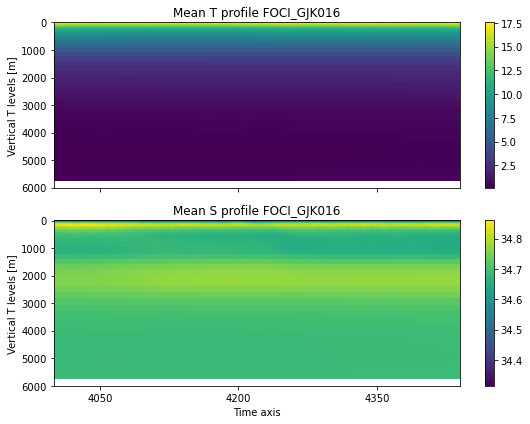

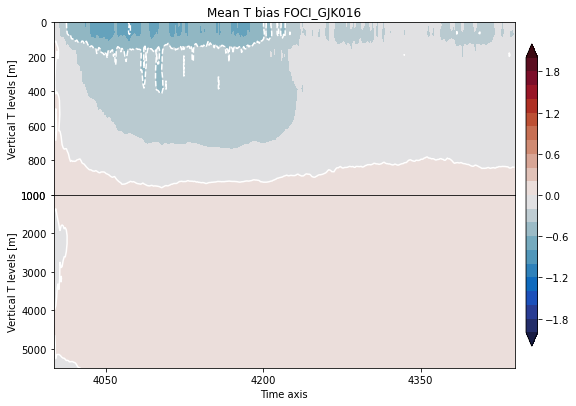

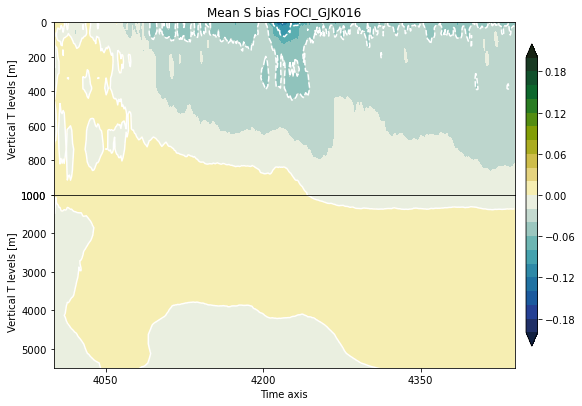

In [12]:
for i in range(0,len(exp_list)):
    
    fig1, ax1 = plt.subplots(2,1,figsize=(8,6))
    
    fig2 = plt.figure(figsize=(8,6))
    ax2 = []
    ax2.append( fig2.add_axes([0.1,0.5,0.8,0.4]) )
    ax2.append( fig2.add_axes([0.1,0.1,0.8,0.4]) )
    cax2 = fig2.add_axes([0.92,0.15,0.02,0.7])
    
    fig3 = plt.figure(figsize=(8,6))
    ax3 = []
    ax3.append( fig3.add_axes([0.1,0.5,0.8,0.4]) )
    ax3.append( fig3.add_axes([0.1,0.1,0.8,0.4]) )
    cax3 = fig3.add_axes([0.92,0.15,0.02,0.7])
    
    toce = toce_list[i]
    soce = soce_list[i]
    toce_anom = toce_anom_list[i]
    soce_anom = soce_anom_list[i]
    
    exp = exp_list[i]
    
    # Annual mean
    toce.plot(x='time',y='deptht',ax=ax1[0],label=exp)
    soce.plot(x='time',y='deptht',ax=ax1[1],label=exp)
    
    tlev1 = np.linspace(-2,2,21)
    tlev2 = np.arange(-2,2.1,0.4)
    tlev3 = np.arange(-2,2.1,0.4)
    slev1 = np.linspace(-0.2,0.2,21)
    slev2 = np.arange(-0.2,0.2,0.04)
    slev3 = np.arange(-0.2,0.2,0.04)
    
    toce_anom.plot.contourf(x='time',y='deptht',ax=ax2[0],cmap=cmocean.cm.balance,levels=tlev1,add_colorbar=False,rasterized=True)
    toce_anom.plot.contour(x='time',y='deptht',ax=ax2[0],colors='w',levels=tlev3,rasterized=True)
    toce_anom.plot.contourf(x='time',y='deptht',ax=ax2[1],cmap=cmocean.cm.balance,levels=tlev1,cbar_ax=cax2,extend='both',rasterized=True)
    toce_anom.plot.contour(x='time',y='deptht',ax=ax2[1],colors='w',levels=tlev2,rasterized=True)
    
    soce_anom.plot.contourf(x='time',y='deptht',ax=ax3[0],cmap=cmocean.cm.delta,levels=slev1,add_colorbar=False,rasterized=True)
    soce_anom.plot.contour(x='time',y='deptht',ax=ax3[0],colors='w',levels=slev3,rasterized=True)
    soce_anom.plot.contourf(x='time',y='deptht',ax=ax3[1],cmap=cmocean.cm.delta,levels=slev1,cbar_ax=cax3,extend='both',rasterized=True)
    soce_anom.plot.contour(x='time',y='deptht',ax=ax3[1],colors='w',levels=slev2,rasterized=True)
    
    ax1[0].set_title('Mean T profile %s' % (exp,))
    ax1[1].set_title('Mean S profile %s' % (exp,))
    
    ax2[0].set_title('Mean T bias %s' % (exp,))
    #ax2[1].set_title('Mean T bias %s' % (exp,))
    ax2[0].set_ylim([0,1000])
    ax2[1].set_ylim([1000,5500])
    cax2.set_label('T [K]')
    
    ax3[0].set_title('Mean S bias %s' % (exp,))    
    #ax3[1].set_title('Mean S bias %s' % (exp,))
    ax3[0].set_ylim([0,1000])
    ax3[1].set_ylim([1000,5500])
    
    for axs in [ax1,ax2,ax3]:
        axs[0].tick_params(labelbottom=False)
        axs[0].set_xlabel('')
        for ax in axs:
            ax.invert_yaxis()

    for fig in [fig1,fig2,fig3]:
        fig.tight_layout()
        
    #fig2.savefig('global_mean_tos_%s.pdf' % (exp,),format='pdf')
    #fig3.savefig('global_mean_sos_%s.pdf' % (exp,),format='pdf')

## Volume-averaged temperature

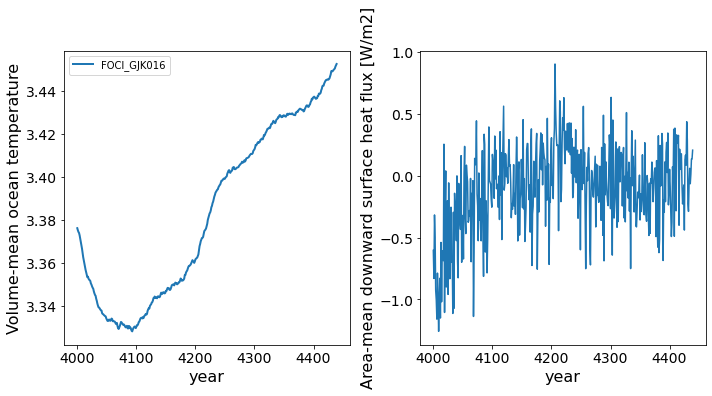

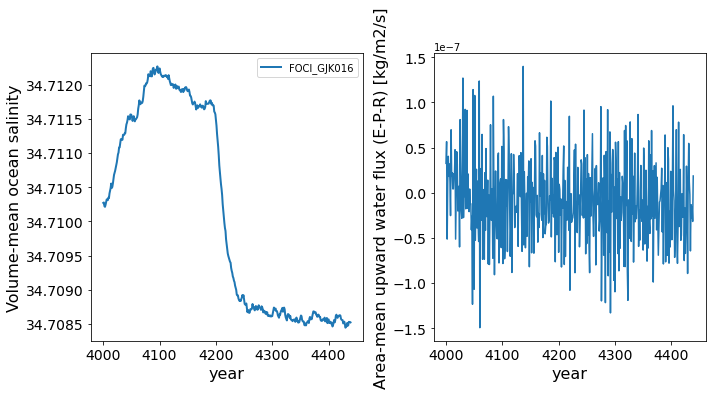

In [14]:
fig1, ax1 = plt.subplots(1,2,figsize=(10,5))

fig2, ax2 = plt.subplots(1,2,figsize=(10,5))

for i in range(0,len(exp_list)):
    toce_1d = toce_list[i]
    soce_1d = soce_list[i]
    
    exp = exp_list[i]
    ds_t = ds_t_all[i]
    
    # Ocean temperature
    tot_vol = (da_orca05_volume * da_orca05_mask_3D).sum(('x','y')) 
    toce = (toce_1d * tot_vol).sum(('deptht')) / tot_vol.sum('deptht')
    
    # Ocean salinity
    soce = (soce_1d * tot_vol).sum(('deptht')) / tot_vol.sum('deptht')
    
    # Surface heat flux
    tot_area = (da_orca05_area * da_orca05_mask).sum(('x','y')) 
    hflux = (ds_t['sohefldo'] * da_orca05_mask * da_orca05_area).sum(('x','y')) / tot_area
    
    # Surface water flux
    wflux = (ds_t['sowaflup'] * da_orca05_mask * da_orca05_area).sum(('x','y')) / tot_area
    
    # Annual mean
    toce_mean = toce.groupby('time.year').mean('time')
    toce_mean.plot(ax=ax1[0],alpha=1,label=exp,lw=2)
    
    soce_mean = soce.groupby('time.year').mean('time')
    soce_mean.plot(ax=ax2[0],alpha=1,label=exp,lw=2)
    
    hflux_mean = hflux.groupby('time.year').mean('time')
    hflux_mean.plot(ax=ax1[1],alpha=1,label=exp)
    
    wflux_mean = wflux.groupby('time.year').mean('time')
    wflux_mean.plot(ax=ax2[1],alpha=1,label=exp)
    
    for ax in [ax1,ax2]:
        for a in ax:
            a.tick_params(labelsize=14)
            t = a.get_xlabel()
            a.set_xlabel(t,fontsize=16)
            t = a.get_ylabel()
            a.set_ylabel(t,fontsize=16)

for ax in [ax1,ax2]:
    ax[0].legend()

ax1[0].set_ylabel('Volume-mean ocean temperature')
ax1[1].set_ylabel('Area-mean downward surface heat flux [W/m2]')
fig1.tight_layout()
#fig1.savefig('volmean_ocean_temp.pdf',format='pdf')

ax2[0].set_ylabel('Volume-mean ocean salinity')
ax2[1].set_ylabel('Area-mean upward water flux (E-P-R) [kg/m2/s]')
fig2.tight_layout()
#fig2.savefig('volmean_ocean_salt.pdf',format='pdf')

## Area-mean ssh

In [18]:
ssh_list = []

for i in range(0,len(exp_list)):
    ds_t = ds_t_all[i]
    exp = exp_list[i]
    
    # Globally averaged 
    tot_area = (da_orca05_area * da_orca05_mask).sum(('x','y')) 
    ssh = (ds_t['sossheig'] * da_orca05_area * da_orca05_mask).sum(('x','y')) / tot_area
    print(ssh)
    
    ssh_list.append(ssh.compute())

<xarray.DataArray (time: 440)>
dask.array<truediv, shape=(440,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 4000-07-01 06:00:00 ... 4439-07-01 06:00:00


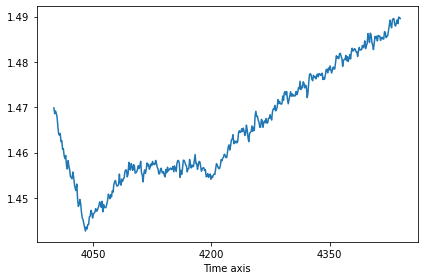

In [19]:
fig, ax = plt.subplots(1,1)

for j, ssh in enumerate( ssh_list ):
    
    ssh.plot(ax=ax, label=exp_list[j])
    
fig.tight_layout()

## Surface fluxes over land, lake, sea, total

In [18]:
flux_scale = 1.0 / (6 * 60 * 60) # /s

toa_net_list = []
sfc_net_list = []
sw_net_list = []
qt_net_list = []
qs_net_list = []

for i, (exp,ds_sfc_r,ds_t) in enumerate( zip(exp_list, ds_sfc_r_all, ds_t_all) ):
    
    # TOA
    toa_net = ds_sfc_r['tsr'] + ds_sfc_r['ttr']
    
    # Surface heat fluxes
    sfc_net = ds_sfc_r['ssr'] + ds_sfc_r['str'] + ds_sfc_r['sshf'] + ds_sfc_r['slhf']
    sfc_sw  = ds_sfc_r['ssr']
    
    # Surface heat flux from NEMO
    tot_area = (da_orca05_area * da_orca05_mask).sum(('x','y')) 
    qt = (ds_t['sohefldo'] * da_orca05_mask * da_orca05_area).sum(('x','y')) / tot_area
    qs = (ds_t['soshfldo'] * da_orca05_mask * da_orca05_area).sum(('x','y')) / tot_area
    qt_net_list.append( qt.compute() )
    qs_net_list.append( qs.compute() )
    
    # Latent heat flux of melting snow over ocean
    tot_area = (da_area_r * da_sea_r).sum('cell').compute() # m2
    sn_lat = (ds_sfc_r['sf'] * da_sea_r).sum('cell').compute() / tot_area * flux_scale # W/m2
    
    # Multiply by area and fraction
    sfc_net_frac = []
    toa_net_frac = []
    
    fracs = [da_lsm_r, da_cl_r, da_sea_r]
    for i in range(0,len(fracs)+1):
        
        if i < len(fracs):
            frac = fracs[i]
            tot_area = (da_area_r * frac).sum('cell').compute() # m2
            net_frac = (sfc_net * frac * da_area_r).sum('cell').compute() # J
            sw_frac  = (sfc_sw * frac * da_area_r).sum('cell').compute() # J
            toa_frac = (toa_net * frac * da_area_r).sum('cell').compute() # J
            
        else:
            tot_area = da_area_r.sum('cell').compute() # m2
            net_frac = (sfc_net * da_area_r).sum('cell').compute() # J
            sw_frac  = (sfc_sw * da_area_r).sum('cell').compute() # J
            toa_frac = (toa_net * da_area_r).sum('cell').compute() # J
        
        sfc_net_frac.append( net_frac / tot_area * flux_scale ) # W/m2
        toa_net_frac.append( toa_frac / tot_area * flux_scale ) # W/m2
    
    sfc_net_list.append(sfc_net_frac)
    toa_net_list.append(toa_net_frac)

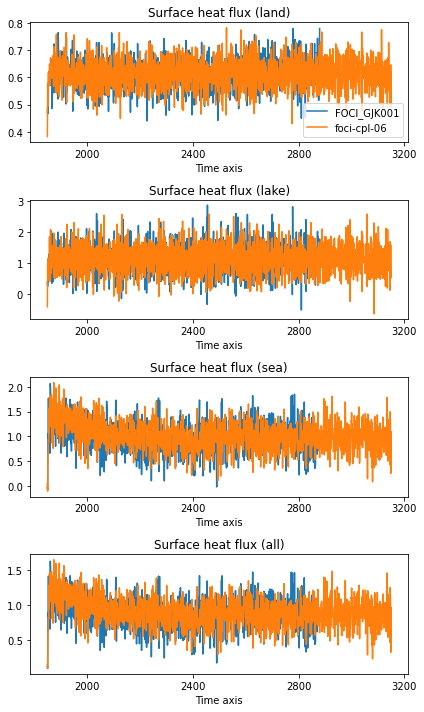

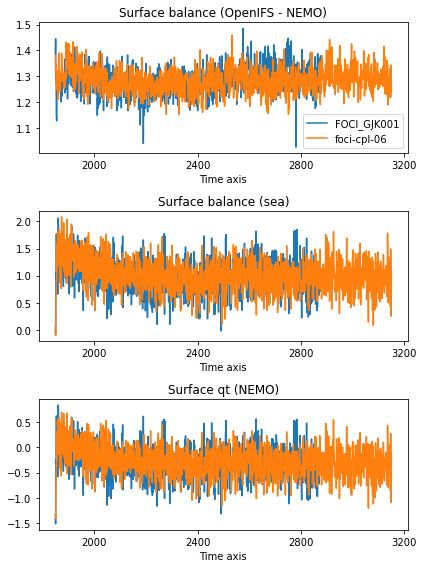

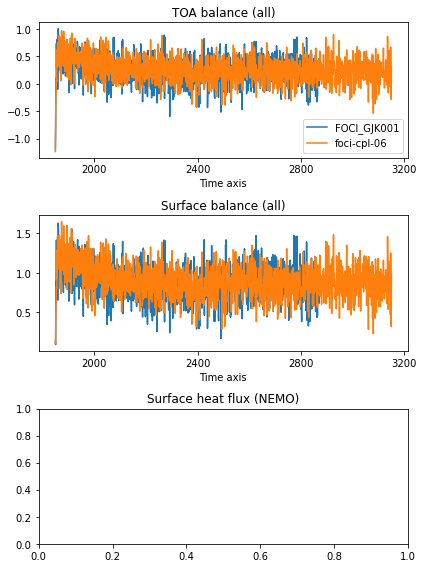

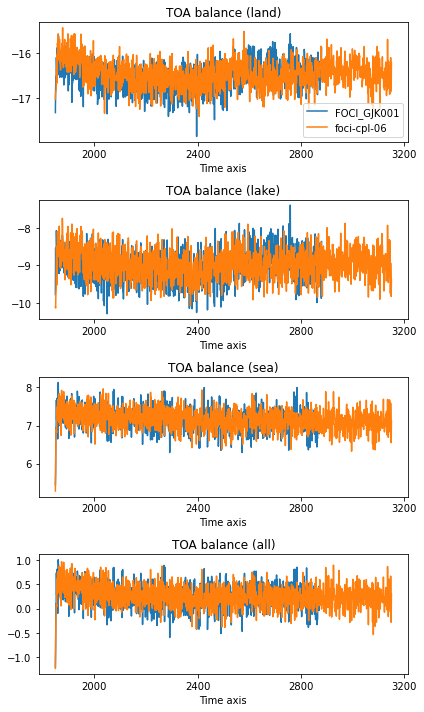

In [19]:
fig1, ax1 = plt.subplots(4,1,figsize=(6,10))

fig2, ax2 = plt.subplots(3,1,figsize=(6,8))
jsea = 2
fig3, ax3 = plt.subplots(3,1,figsize=(6,8))
jglo = 3

fig4, ax4 = plt.subplots(4,1,figsize=(6,10))

for i, (exp,sfc_net,toa_net,qt) in enumerate( zip(exp_list, sfc_net_list, toa_net_list, qt_net_list) ):
    
    for j in range(0,4):
        sfc_net[j].plot(ax=ax1[j],label=exp)
        toa_net[j].plot(ax=ax4[j],label=exp)
    
    #toa_net[jsea].plot(ax=ax2[0],label=exp)
    sfc_net[jsea].plot(ax=ax2[1],label=exp)
    qt.plot(ax=ax2[2],label=exp)
    (sfc_net[jsea] - qt).plot(ax=ax2[0],label=exp)
    
    toa_net[jglo].plot(ax=ax3[0],label=exp)
    sfc_net[jglo].plot(ax=ax3[1],label=exp)
    
    #toa_net[jr].plot(ax=ax2[0],label=exp)
    
ax1[0].legend()
ax1[0].set_title('Surface heat flux (land)')
ax1[1].set_title('Surface heat flux (lake)')
ax1[2].set_title('Surface heat flux (sea)')
ax1[3].set_title('Surface heat flux (all)')
fig1.tight_layout()
fig1.savefig('surface_heat_flux.pdf',format='pdf')

ax4[0].legend()
ax4[0].set_title('TOA balance (land)')
ax4[1].set_title('TOA balance (lake)')
ax4[2].set_title('TOA balance (sea)')
ax4[3].set_title('TOA balance (all)')
fig4.tight_layout()
fig4.savefig('toa_balance.pdf',format='pdf')

ax2[0].legend()
#ax2[0].set_title('TOA balance (sea)')
ax2[1].set_title('Surface balance (sea)')
ax2[2].set_title('Surface qt (NEMO)')
ax2[0].set_title('Surface balance (OpenIFS - NEMO)')
fig2.tight_layout()
fig2.savefig('sea_balance.pdf',format='pdf')

ax3[0].legend()
ax3[0].set_title('TOA balance (all)')
ax3[1].set_title('Surface balance (all)')
ax3[2].set_title('Surface heat flux (NEMO)')
fig3.tight_layout()
#fig2.savefig('surface_heat_flux.pdf',format='pdf')


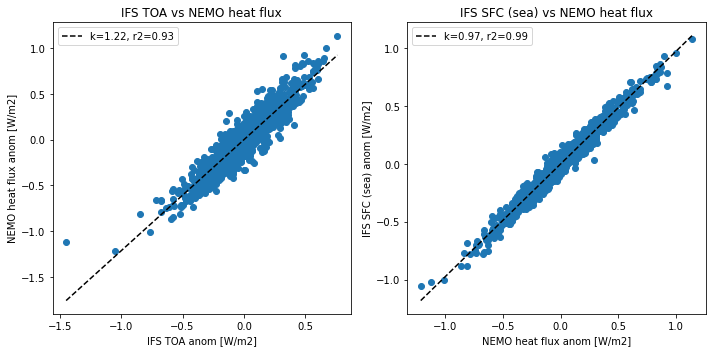

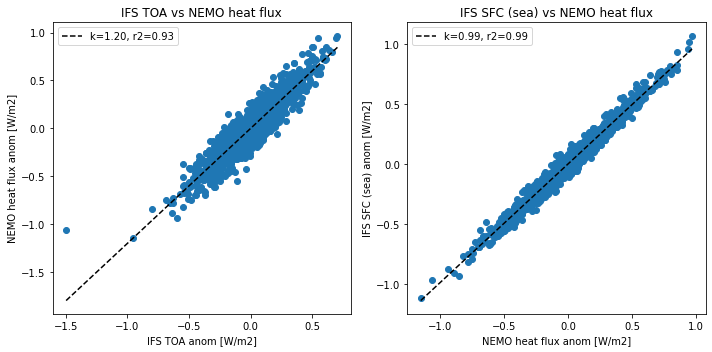

In [41]:
for i, (exp,sfc_net,toa_net,qt) in enumerate( zip(exp_list, sfc_net_list, toa_net_list, qt_net_list) ):
    
    fig1, ax1 = plt.subplots(1,2,figsize=(10,5))
    
    #for j in range(0,4):
    #    sfc_net[j].plot(ax=ax1[j],label=exp)
    #    toa_net[j].plot(ax=ax4[j],label=exp)
    
    #toa_net[jsea].plot(ax=ax2[0],label=exp)
    #sfc_net[jsea].plot(ax=ax2[1],label=exp)
    #qt.plot(ax=ax2[2],label=exp)
    #(sfc_net[jsea] - qt).plot(ax=ax2[0],label=exp)
    
    #toa_net[jglo].plot(ax=ax3[0],label=exp)
    #sfc_net[jglo].plot(ax=ax3[1],label=exp)
    
    # Qt anom
    qt_anom = qt - qt.mean('time')
    # TOA anom
    toa_anom = toa_net[jglo] - toa_net[jglo].mean('time')
    
    ax1[0].scatter(toa_anom, qt_anom)
    beta = (qt_anom * toa_anom).sum() / (toa_anom**2).sum()
    x = [toa_anom.values.min(),toa_anom.values.max()]
    y = x * beta.values
    cov = (qt_anom * toa_anom).sum()
    var = ((qt_anom*qt_anom).sum() * (toa_anom*toa_anom).sum())**0.5
    r2 = cov / var
    stats = 'k=%0.2f, r2=%0.2f' % (beta.values,r2)
    ax1[0].plot(x, y, '--k', label=stats)
    ax1[0].set_title('IFS TOA vs NEMO heat flux')
    ax1[0].legend()
    ax1[0].set_ylabel('NEMO heat flux anom [W/m2]')
    ax1[0].set_xlabel('IFS TOA anom [W/m2]')
    
    # Sfc anom over sea
    sfc_anom = sfc_net[jsea] - sfc_net[jsea].mean('time')
    
    ax1[1].scatter(qt_anom, sfc_anom)
    beta = (qt_anom * sfc_anom).sum() / (qt_anom**2).sum()
    x = [qt_anom.values.min(),qt_anom.values.max()]
    y = x * beta.values
    cov = (qt_anom * sfc_anom).sum()
    var = ((qt_anom*qt_anom).sum() * (sfc_anom*sfc_anom).sum())**0.5
    r2 = cov / var
    stats = 'k=%0.2f, r2=%0.2f' % (beta.values,r2)
    ax1[1].plot(x, y, '--k', label=stats)
    ax1[1].set_title('IFS SFC (sea) vs NEMO heat flux')
    ax1[1].legend()
    ax1[1].set_xlabel('NEMO heat flux anom [W/m2]')
    ax1[1].set_ylabel('IFS SFC (sea) anom [W/m2]')
    
    fig1.tight_layout()
    fig1.savefig('toa_sfc_qt_%s.pdf' % (exp,),format='pdf')
    
    

In [20]:
flux_scale = 1.0 / (6*60*60)
times = slice('1850-01-01','2150-01-01')


for i in range(0,len(exp_list)):
    exp = exp_list[i]
    ds_t = ds_t_all[i]
    ds_sfc = ds_sfc_all[i]
    
    # Ocean heat flux (solar + thermal + sensible + latent)
    oce_hflx = ds_t['sohefldo']
    
    # Atmosphere heat flux
    atm_ssr = ds_sfc['ssr'] * flux_scale
    atm_str = ds_sfc['str'] * flux_scale
    atm_shf = ds_sfc['sshf'] * flux_scale
    atm_lhf = ds_sfc['slhf'] * flux_scale
    atm_hflx = atm_ssr + atm_str + atm_shf + atm_lhf
    
    # Ocean water flux
    oce_empmr = ds_t['sowaflup']
    
    # Atm water flux
    atm_e = ds_sfc['e'] * flux_scale * 1000
    atm_p = ds_sfc['tp'] * flux_scale * 1000
    atm_emp = atm_e + atm_p
    
    # Heat fluxes
    levels = np.linspace(-250,250,50)
    atm_hflx_mean = atm_hflx.sel(time=times).mean('time')
    atm_hflx_mean.plot.contourf(ax=ax1[0],levels=levels)
    ax1[0].set_title('Atm net sfc hflux')
    
    oce_hflx_mean = oce_hflx.sel(time=times).mean('time')
    oce_hflx_mean.plot.contourf(ax=ax1[1],levels=levels)
    ax1[1].set_title('Oce net sfc hflux')
    
    # Water fluxes
    levels = np.linspace(-1.5,1.5,20) / 10000
    atm_emp_mean = atm_emp.sel(time=times).mean('time')
    atm_emp_mean.plot.contourf(ax=ax2[0],levels=levels)
    ax2[0].set_title('Atm P-E')
    
    oce_empmr_mean = oce_empmr.sel(time=times).mean('time')
    (-oce_empmr_mean).plot(ax=ax2[1],levels=levels)
    ax2[1].set_title('Oce P-E')
    
    #for ax in [ax1,ax2]:
    #    for a in ax:
    #        a.tick_params(labelsize=14)
    #        t = a.get_xlabel()
    #        a.set_xlabel(t,fontsize=16)
    #        t = a.get_ylabel()
    #        a.set_ylabel(t,fontsize=16)

fig1.tight_layout()

fig2.tight_layout()